In [1]:
import sys
sys.path.append('../../../')
import RdPCA.src.model as rdpca

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt

from scipy.io import mmread
from openTSNE import TSNE

In [118]:
exp_data = mmread('/data01/hanbin973/zheng/facs/%s/matrix.mtx' % 'cd14').toarray().astype(float)
exp_data_col = pd.read_csv('/data01/hanbin973/zheng/facs/cd14/barcodes.tsv', sep='\t', header=None)[0]
exp_data_row = pd.read_csv('/data01/hanbin973/cd14.genes.csv')['x'].values
hvg = pd.read_csv('/data01/hanbin973/zheng/facs/cd14/hvg.vst.tsv', index_col=0)['x'].values
exp_data_meta = pd.read_csv('/data01/hanbin973/zheng/facs/cd14/meta.csv', index_col=0)
size_factor = exp_data_meta['nCount_RNA']/exp_data_meta['nCount_RNA'].mean()

In [123]:
device_cuda_list = [torch.device("cuda:{}".format(i)) for i in range(6)[::-1]]
torch.set_default_tensor_type(torch.FloatTensor)
dtype = torch.float32
data = pd.DataFrame(exp_data, columns=exp_data_col, index=pd.read_csv('/data01/hanbin973/cd14.genes.csv')['x'])
expr_mat = torch.tensor(data.T.loc[:,hvg[:1000]].values, dtype=dtype)
cc_mat = torch.tensor(exp_data_meta.loc[:,['S.Score', 'G2M.Score']].values, dtype=dtype)
sf = torch.tensor(size_factor, dtype=dtype)
batch_mat = torch.tensor(np.zeros((expr_mat.shape[0],1)), dtype=dtype)
device = device_cuda_list[3]

In [129]:
import imp
imp.reload(rdpca)
torch.manual_seed(0)
n_lat = 10
red = rdpca.fit_pca_linear(expr_mat, n_lat, cc_mat, sf, batch_mat, device=device)

step 0: loss 132.06
step 50: loss -146.69
step 100: loss -161.94
step 150: loss -164.75
step 200: loss -165.60


In [131]:
np.savetxt('rdpca.csv', red.detach().cpu().numpy(), delimiter=',')

# RdPCA

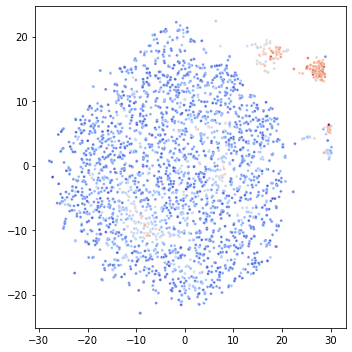

In [130]:
np.random.seed(1)
tsne2 = TSNE(n_jobs=8, perplexity=70).fit(red.detach().cpu().numpy())

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True),
                s=8)
plt.tight_layout()

In [142]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_rdpca.csv')

# PCA

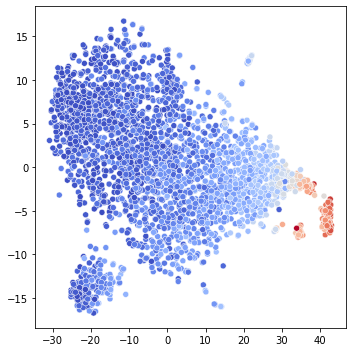

In [75]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('pca.csv', index_col=0).iloc[:,:10].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True))
plt.tight_layout()

# SCT

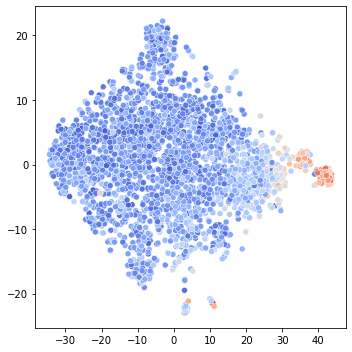

In [144]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('sct.csv', index_col=0).iloc[:,:10].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True))
plt.tight_layout()

In [145]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_sct.csv')

# GLM-PCA

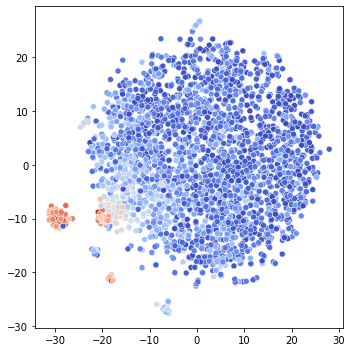

In [78]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('glmpca.csv', index_col=0).iloc[:,:10].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True))
plt.tight_layout()

# ZINB-WaVE

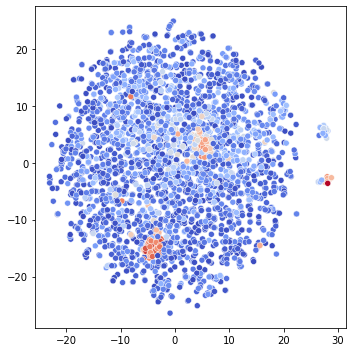

In [5]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('zinbwave.csv', index_col=0).iloc[:,:10].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True))
plt.tight_layout()

# Gene expr

In [152]:
gene_expr = pd.concat([data.loc[['CLEC9A', 'CLEC10A', 'CD14'],:].T,exp_data_meta['nCount_RNA']],axis=1)
gene_expr.to_csv('exprs.csv')

In [153]:
pd.read_csv('exprs.csv', index_col=0).loc[:,]

,CLEC9A,CLEC10A,CD14,nCount_RNA
0,,,,
AAACATACCACTAG-1,0.0,0.0,2.0,658
AAACATACGTTCAG-1,0.0,0.0,3.0,700
AAACATTGACGGTT-1,0.0,0.0,1.0,738
AAACATTGCTTCGC-1,0.0,0.0,0.0,703
AAACATTGGGCAAG-1,0.0,0.0,0.0,1544
...,...,...,...,...
TTTCGAACGCTAAC-1,0.0,0.0,0.0,744
TTTCGAACTCCTGC-1,0.0,0.0,1.0,909
TTTGACTGAGTAGA-1,0.0,2.0,3.0,2998


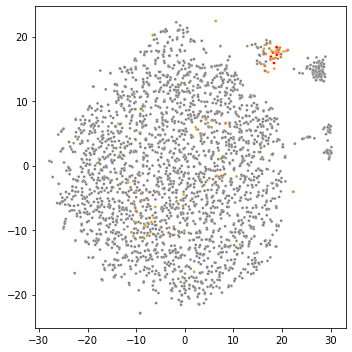

In [143]:
cluster_rdpca = pd.read_csv('cluster_rdpca.csv', index_col=0)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(1+data.loc['CLEC10A',:]*1e-1), legend=False,
                palette=cmap_cont,
                s=8)
plt.tight_layout()